### Impotación de librerias

In [83]:
# Librerías de manejo de archivos y datos
import os
import pandas as pd
import numpy as np

# Librerías de visualización
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Librerías de procesamiento de imágenes
import cv2

# Librerías de evaluación y métricas de modelos
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# Librerías de clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


### Funciones Necesarias para el Filtrado y Análisis de Contornos en Imágenes

In [84]:
# Función para el filtrado de contornos
def filter_contours(contours, min_size, max_size, image, min_influence):
    filtered_contours = []  # Lista donde se almacenarán los contornos filtrados
    image_area = image.shape[0] * image.shape[1]  # Área total de la imagen (alto * ancho)
    
    for contour in contours:  # Itera sobre todos los contornos encontrados
        area = cv2.contourArea(contour)  # Calcula el área del contorno
        x, y, w, h = cv2.boundingRect(contour)  # Obtiene las coordenadas del rectángulo envolvente del contorno

        # Calcula la influencia del contorno en relación con el área total de la imagen
        influence = area / image_area

        # Filtra contornos según el tamaño, la influencia y la posición
        if min_size <= area <= max_size and influence >= min_influence:
            # Si el contorno está demasiado cerca de los bordes, se ignora
            if x > 12 and y > 12 and x + w < image.shape[1] - 12 and y + h < image.shape[0] - 12:
                filtered_contours.append(contour)  # Agrega el contorno a la lista filtrada

    return filtered_contours  # Devuelve la lista de contornos filtrados

def segment_contours(contours, image_shape):
    square_contours = []  # Lista para los contornos cuadrados
    rectangular_contours = []  # Lista para los contornos rectangulares
    for contour in contours:  # Itera sobre todos los contornos
        area = cv2.contourArea(contour)  # Calcula el área del contorno
        area_ratio = area / (image_shape[0] * image_shape[1])  # Relación del área del contorno con el área total de la imagen
        x, y, w, h = cv2.boundingRect(contour)  # Obtiene las coordenadas del rectángulo envolvente
        aspect_ratio = w / h  # Relación de aspecto (ancho / alto)

        # Clasifica el contorno como cuadrado o rectangular dependiendo de su relación de aspecto y área
        if 0.6 <= aspect_ratio <= 1.5 and area_ratio > 0.06:
            square_contours.append(contour)  # Si es cuadrado, se agrega a la lista de cuadrados
        else:
            rectangular_contours.append(contour)  # Si no es cuadrado, se agrega a la lista de rectangulares
    return square_contours, rectangular_contours  # Devuelve las listas de contornos cuadrados y rectangulares

# Función para filtrar contornos dentro de otros contornos
def filter_inside_contours(contours):
    filtered_contours = []  # Lista donde se almacenarán los contornos que no están dentro de otros
    for contour in contours:  # Itera sobre todos los contornos
        parent_contour = None  # Variable para almacenar el contorno que contiene al contorno actual
        for other_contour in contours:  # Compara con todos los otros contornos
            if contour is not other_contour:  # Si el contorno no es el mismo que el actual
                # Verifica si todos los puntos del contorno actual están dentro del otro contorno
                if all(
                    cv2.pointPolygonTest(other_contour, (int(point[0][0]), int(point[0][1])), False) > 0
                    for point in contour
                ):
                    if parent_contour is None or cv2.contourArea(other_contour) > cv2.contourArea(parent_contour):
                        parent_contour = other_contour  # Actualiza el contorno padre si es más grande
        if parent_contour is None:  # Si no se encontró un contorno padre, agrega el contorno a la lista
            filtered_contours.append(contour)
    return filtered_contours  # Devuelve los contornos que no están dentro de otros

def separate_contours_by_segments(contours, image_width):
    segments = []  # Lista para almacenar los segmentos
    for i in range(4):
        segments.append([])  # Inicializa 4 segmentos vacíos (uno para cada cuarto de la imagen)
    for contour in contours:  # Itera sobre todos los contornos
        x, y, w, h = cv2.boundingRect(contour)  # Obtiene el rectángulo envolvente del contorno
        center_x = x + w // 2  # Calcula la posición horizontal del centro del contorno
        segment = center_x // (image_width // 4)  # Determina a qué segmento pertenece el contorno
        segments[segment].append(contour)  # Agrega el contorno al segmento correspondiente
    return segments  # Devuelve la lista de segmentos

def get_orientation(contours):
    orientations = []  # Lista para almacenar la orientación de cada contorno
    for contour in contours:  # Itera sobre todos los contornos
        x, y, w, h = cv2.boundingRect(contour)  # Obtiene el rectángulo envolvente
        if w > h:  # Si el ancho es mayor que la altura, es una orientación horizontal
            orientations.append('horizontal')
        else:  # Si la altura es mayor que el ancho, es una orientación vertical
            orientations.append('vertical')
    return orientations  # Devuelve la lista de orientaciones

def order_contours(segments):
    ordered_segments = []  # Lista para los segmentos ordenados
    for segment in segments:  # Itera sobre cada segmento
        if len(segment) <= 1:  # Si el segmento tiene uno o ningún contorno, se agrega tal cual
            ordered_segments.append(segment)
        elif len(segment) == 2:  # Si el segmento tiene dos contornos
            x1, y1, w1, h1 = cv2.boundingRect(segment[0])  # Obtiene el rectángulo envolvente del primer contorno
            x2, y2, w2, h2 = cv2.boundingRect(segment[1])  # Obtiene el rectángulo envolvente del segundo contorno
            if w1 > h1 and w2 > h2:  # Si ambos contornos son horizontales
                if y1 < y2:
                    ordered_segments.append([segment[0], segment[1]])  # Ordena por la posición vertical
                else:
                    ordered_segments.append([segment[1], segment[0]])  # Ordena por la posición vertical inversa
            elif w1 < h1 and w2 < h2:  # Si ambos contornos son verticales
                if x1 < x2:
                    ordered_segments.append([segment[0], segment[1]])  # Ordena por la posición horizontal
                else:
                    ordered_segments.append([segment[1], segment[0]])  # Ordena por la posición horizontal inversa
        else:
            ordered_segments.append(segment)  # Si hay más de dos contornos, se agrega sin cambios
    return ordered_segments  # Devuelve los segmentos ordenados

def get_area_ratio(contours, image):
    image_area = (image.shape[0] * image.shape[1]) / 4  # Calcula el área de un cuarto de la imagen
    area_ratios = []  # Lista para almacenar las relaciones de área de los contornos
    for contour in contours:  # Itera sobre todos los contornos
        area = cv2.contourArea(contour)  # Calcula el área del contorno
        area_ratio = area / image_area  # Relación del área del contorno con el área de un cuarto de la imagen
        area_ratios.append(round(area_ratio, 3))  # Agrega la relación de área a la lista
    return area_ratios  # Devuelve la lista de relaciones de área

# Decodifica el número del segmento dado un conjunto de información de segmentos
def decode_number(segment_info):
    segment_number = ''  # Inicializa la cadena que almacenará el número decodificado
    for i in range(4):  # Itera sobre los 4 segmentos
        # Validar si el segmento tiene la estructura esperada
        if i >= len(segment_info):
            segment_number += 'X'  # Si no hay información, agrega 'X'
            continue
        
        num_contours = segment_info[i]['num_contours']  # Obtiene el número de contornos del segmento
        orientation = segment_info[i]['orientation']  # Obtiene las orientaciones de los contornos
        area_ratios = segment_info[i]['area_ratios']  # Obtiene las relaciones de área
        area_ratios_relation = segment_info[i]['area_ratios_relation']  # Relación entre áreas de los contornos

        # Se decodifica el número basado en las características del segmento
        if num_contours == 0:
            segment_number += '0'
        elif num_contours == 1:
            if orientation[0] == 'horizontal':
                segment_number += '8'
            else:
                if area_ratios[0] < 0.15:
                    segment_number += '1'
                else:
                    segment_number += '5'
        elif num_contours == 2:
            if orientation[0] == 'horizontal':
                if area_ratios_relation > 1.2:
                    segment_number += '7'
                elif area_ratios_relation < 0.8:
                    segment_number += '9'
                else:
                    segment_number += '3'
            else:
                if area_ratios_relation > 1.2:
                    segment_number += '6'
                elif area_ratios_relation < 0.8:
                    segment_number += '4'
                else:
                    segment_number += '2'
        else:
            segment_number += 'X'  # Si hay más de dos contornos, agrega 'X'
    return segment_number  # Devuelve el número decodificado

def extract_segment_info(segment, image):
    num_contours = len(segment)  # Obtiene el número de contornos en el segmento
    orientations = [
        'horizontal' if cv2.boundingRect(c)[2] > cv2.boundingRect(c)[3] else 'vertical'
        for c in segment
    ]  # Obtiene la orientación de cada contorno (horizontal o vertical)
    area_ratios = get_area_ratio(segment, image)  # Obtiene las relaciones de área de los contornos
    if len(segment) == 2:  # Si hay dos contornos en el segmento, calcula la relación de área entre ellos
        area_ratio_relation = round(
            cv2.contourArea(segment[0]) / cv2.contourArea(segment[1]), 3
        )
    else:
        area_ratio_relation = None  # Si solo hay un contorno, la relación no es relevante

    return {
        'num_contours': num_contours,  # Número de contornos en el segmento
        'orientation': orientations,  # Orientaciones de los contornos
        'area_ratios': area_ratios,  # Relaciones de área de los contornos
        'area_ratios_relation': area_ratio_relation  # Relación entre las áreas de los contornos
    }

segment_info_global = []  # Variable global para almacenar la información de los segmentos

def process_image(image_path):
    image = cv2.imread(image_path)  # Lee la imagen desde el archivo
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convierte la imagen a escala de grises
    image_blur = cv2.GaussianBlur(image_gray, (11, 11), 0)  # Aplica un desenfoque gaussiano para reducir el ruido
    image_thresh = cv2.adaptiveThreshold(image_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)  # Aplica umbralización adaptativa
    image_eroded = cv2.erode(image_thresh, np.ones((3, 3), np.uint8), iterations=1)  # Aplica erosión para limpiar pequeños objetos
    contours, _ = cv2.findContours(image_eroded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  # Encuentra los contornos en la imagen

    # Filtra y segmenta los contornos
    filtered_contours = filter_contours(contours, 200, 25000, image_eroded, 0.01)
    _, rectangular_contours = segment_contours(filtered_contours, image_eroded.shape)
    rectangular_contours = filter_inside_contours(rectangular_contours)

    # Separa y procesa los segmentos
    segments = separate_contours_by_segments(rectangular_contours, image.shape[1])
    ordered_segments = order_contours(segments)

    # Extraer información de cada segmento
    segment_info = [extract_segment_info(segments, image) for segments in ordered_segments]

    number_decode = decode_number(segment_info)  # Decodifica el número basado en la información de los segmentos
    
    # Almacenar la información de segmentos de esta imagen en una lista global
    segment_info_global.append(segment_info)

    return number_decode  # Devuelve el número decodificado


### Matriz de confusión

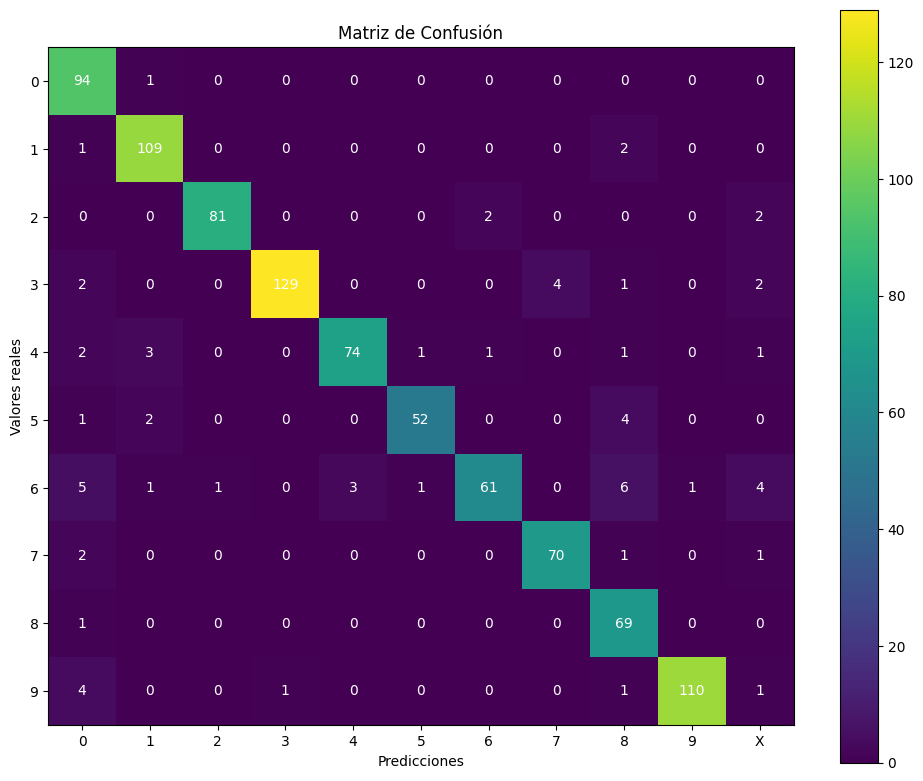

In [85]:
# Inicializar la matriz de confusión con 11 clases (0-9 y X)
num_clases = 11  # Clases 0-9 y "X"
matriz_confusion = np.zeros((10, num_clases), dtype=int)

# Lista para almacenar las imágenes mal predichas
imagenes_mal_predichas = []

# Procesar las imágenes en el directorio
folder_path = "Processed Images"
# Ruta de la carpeta de destino para las imágenes mal predichas
carpeta_destino = "ImagenesProblematicas"
os.makedirs(carpeta_destino, exist_ok=True)  # Crear la carpeta si no existe

archivos = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))]

for file_name in archivos:
    # Leer la imagen
    image_path = os.path.join(folder_path, file_name)
    image = cv2.imread(image_path)

    # Extraer los primeros 4 dígitos del nombre del archivo
    digitos_imagen = file_name[:4]  # Los primeros 4 dígitos del nombre
    digitos_imagen_array = [int(d) for d in digitos_imagen]

    # Predecir los 4 dígitos utilizando tu función `process_image`
    codigo_segmentos = process_image(image_path)

    # Validar que el resultado tenga exactamente 4 caracteres
    if len(codigo_segmentos) < 4:
        codigo_segmentos += "X" * (4 - len(codigo_segmentos))  # Rellenar con 'X' si es necesario
    codigo_segmentos_array = []
    for char in codigo_segmentos:
        if char.isdigit():
            codigo_segmentos_array.append(int(char))
        else:
            codigo_segmentos_array.append(10)  # Asignar 'X' como clase 11

    # Añadir `valor_real` a cada segmento en `segment_info_global`
    for i, segment in enumerate(segment_info_global[-1]):  # Usar la última entrada añadida por `process_image`
        if i < len(digitos_imagen_array):  # Validar índices
            segment["valor_real"] = digitos_imagen_array[i]
        else:
            segment["valor_real"] = None  # Si falta información, asignar None

    # Comparar los códigos
    for j in range(4):  # Comparar los 4 dígitos
        fila = digitos_imagen_array[j]
        columna = codigo_segmentos_array[j]
        matriz_confusion[fila, columna] += 1

        # Si no coinciden, agregar el nombre de la imagen y la posición del error
        if fila != columna:
            imagenes_mal_predichas.append({
                "archivo": file_name,
                "posición": j + 1,
                "real": fila,
                "predicción": columna
            })
    # Si la imagen está en las mal predichas, moverla a la carpeta problemática
    if any(item["archivo"] == file_name for item in imagenes_mal_predichas):
        destino_imagen = os.path.join(carpeta_destino, file_name)


# Mostrar las imágenes mal predichas para poder corregir errores de procesado
# print("Imágenes mal predichas:")
# for error in imagenes_mal_predichas:
#     real_label = str(error["real"]) if error["real"] < 10 else "X"
#     pred_label = str(error["predicción"]) if error["predicción"] < 10 else "X"
#     print(f"Archivo: {error['archivo']}, Posición: {error['posición']}, Real: {real_label}, Predicción: {pred_label}")
    
# Crear un heatmap de la matriz de confusión
plt.figure(figsize=(10, 8))
plt.imshow(matriz_confusion, interpolation='nearest', cmap='viridis')
plt.title("Matriz de Confusión")
plt.colorbar()
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")

# Etiquetas de clases
x_labels = [str(i) for i in range(10)] + ["X"]
y_labels = [str(i) for i in range(10)]
plt.xticks(np.arange(num_clases), x_labels)
plt.yticks(np.arange(10), y_labels)

# Mostrar los valores en la matriz
for i in range(10):
    for j in range(num_clases):
        plt.text(j, i, str(matriz_confusion[i, j]), ha='center', va='center', color='white')

plt.tight_layout()
plt.show()

### Figuras de mérito

In [86]:
# Listas para almacenar los valores reales y las predicciones
valores_reales = []  # Para almacenar las clases reales (0-9)
predicciones = []  # Para almacenar las clases predichas (0-9 y X)

# Rellenar las listas `valores_reales` y `predicciones` a partir de la matriz de confusión
for i in range(10):  # Iterar sobre las filas de la matriz (valores reales: 0-9)
    for j in range(num_clases):  # Iterar sobre las columnas de la matriz (predicciones: 0-9 y 'X')
        # Para cada celda (i, j) en la matriz de confusión, agregar el valor real `i` y la predicción `j` tantas veces como la cantidad que aparece en la matriz de confusión
        valores_reales.extend([i] * matriz_confusion[i, j])  # Agregar el valor real `i` (repetido según el número de ocurrencias)
        predicciones.extend([j] * matriz_confusion[i, j])  # Agregar la predicción `j` (repetido según el número de ocurrencias)

# Calcular las métricas de desempeño utilizando las listas `valores_reales` y `predicciones`
accuracy = accuracy_score(valores_reales, predicciones)  # Exactitud: proporción de predicciones correctas
precision = precision_score(valores_reales, predicciones, average='weighted', zero_division=0)  # Precisión ponderada
recall = recall_score(valores_reales, predicciones, average='weighted', zero_division=0)  # Recall ponderado
f1 = f1_score(valores_reales, predicciones, average='weighted', zero_division=0)  # F1-Score ponderado

# Mostrar las métricas calculadas con 4 decimales
print(f"Precisión (Accuracy): {accuracy:.4f}")  
print(f"Precisión (Precision): {precision:.4f}")  
print(f"Recall: {recall:.4f}")  
print(f"F1-Score: {f1:.4f}")  


Precisión (Accuracy): 0.9269
Precisión (Precision): 0.9436
Recall: 0.9269
F1-Score: 0.9322


### Confusiones mas frecuentes

In [87]:
# Función para obtener las confusiones más frecuentes en la matriz de confusión
def obtener_confusiones(matriz_confusion):
    confusiones = []  # Lista para almacenar las confusiones encontradas
    
    # Recorrer las filas de la matriz de confusión (valores reales)
    for i in range(matriz_confusion.shape[0]):  
        # Recorrer las columnas de la matriz de confusión (predicciones)
        for j in range(matriz_confusion.shape[1]):
            # Verificar si no es la diagonal principal y si hay confusión 
            if i != j and matriz_confusion[i, j] > 0:
                # Si hay una confusión, agregarla a la lista de confusiones
                confusiones.append(((i, j), matriz_confusion[i, j]))
    
    # Ordenar las confusiones por la cantidad de ocurrencias en orden descendente
    confusiones.sort(key=lambda x: x[1], reverse=True)
    return confusiones  # Retornar la lista de confusiones ordenadas

# Obtener las confusiones más frecuentes utilizando la matriz de confusión
confusiones_mas_frecuentes = obtener_confusiones(matriz_confusion)

# Imprimir las confusiones más frecuentes
print("Confusiones más frecuentes:")
for (real, pred), cantidad in confusiones_mas_frecuentes:
    # Convertir los valores reales y las predicciones a texto, mostrando "X" si es necesario
    real_label = str(real) if real < 10 else "X"
    pred_label = str(pred) if pred < 10 else "X"
    # Imprimir las confusiones con su cantidad
    print(f"Real: {real_label}, Predicción: {pred_label}, Cantidad: {cantidad}")


Confusiones más frecuentes:
Real: 6, Predicción: 8, Cantidad: 6
Real: 6, Predicción: 0, Cantidad: 5
Real: 3, Predicción: 7, Cantidad: 4
Real: 5, Predicción: 8, Cantidad: 4
Real: 6, Predicción: X, Cantidad: 4
Real: 9, Predicción: 0, Cantidad: 4
Real: 4, Predicción: 1, Cantidad: 3
Real: 6, Predicción: 4, Cantidad: 3
Real: 1, Predicción: 8, Cantidad: 2
Real: 2, Predicción: 6, Cantidad: 2
Real: 2, Predicción: X, Cantidad: 2
Real: 3, Predicción: 0, Cantidad: 2
Real: 3, Predicción: X, Cantidad: 2
Real: 4, Predicción: 0, Cantidad: 2
Real: 5, Predicción: 1, Cantidad: 2
Real: 7, Predicción: 0, Cantidad: 2
Real: 0, Predicción: 1, Cantidad: 1
Real: 1, Predicción: 0, Cantidad: 1
Real: 3, Predicción: 8, Cantidad: 1
Real: 4, Predicción: 5, Cantidad: 1
Real: 4, Predicción: 6, Cantidad: 1
Real: 4, Predicción: 8, Cantidad: 1
Real: 4, Predicción: X, Cantidad: 1
Real: 5, Predicción: 0, Cantidad: 1
Real: 6, Predicción: 1, Cantidad: 1
Real: 6, Predicción: 2, Cantidad: 1
Real: 6, Predicción: 5, Cantidad: 1


### Diagrama de dispersión de los valores reales y sus predicciones

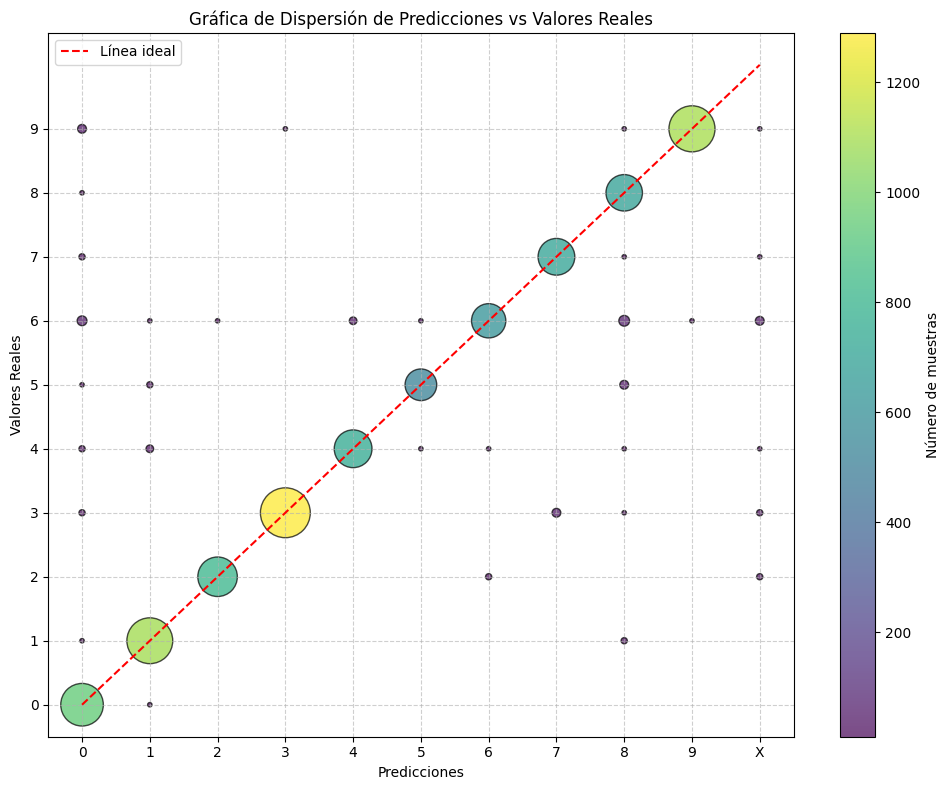

In [88]:
# Crear los datos para la gráfica de dispersión
x = []
y = []
sizes = []

# Recorrer la matriz de confusión
for i in range(10):  # Valores reales (eje y)
    for j in range(num_clases):  # Predicciones (eje x)
        if matriz_confusion[i, j] > 0:  # Solo considerar puntos con datos
            x.append(j)  # Predicción
            y.append(i)  # Valor real
            sizes.append(matriz_confusion[i, j] * 10)  # Escalar el tamaño

# Crear la figura
plt.figure(figsize=(10, 8))

# Dibujar la línea ideal (y = x)
plt.plot(range(11), range(11), linestyle='--', color='red', label='Línea ideal')

# Crear la gráfica de dispersión
scatter = plt.scatter(x, y, s=sizes, c=sizes, cmap='viridis', alpha=0.7, edgecolor='k')

# Etiquetas y leyenda
plt.colorbar(scatter, label='Número de muestras')
plt.title('Gráfica de Dispersión de Predicciones vs Valores Reales')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.xticks(range(11), [str(i) for i in range(10)] + ["X"])
plt.yticks(range(10), [str(i) for i in range(10)])
plt.legend()

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Creación de un Dataframe con cada segemento de cada imagen , sus características y su valor real

In [89]:
# Extraer los nombres de archivo de las imágenes mal predichas
imagenes_mal_predichas_nombres = [item["archivo"] for item in imagenes_mal_predichas]

# Convertir los resultados en un DataFrame para facilitar el análisis
data = []  # Lista para almacenar los datos a convertir en DataFrame
new_segment_info_global = []  # Lista para almacenar los segmentos no mal predichos

# Recorrer todas las imágenes y sus segmentos
for image_idx, segment_info in enumerate(segment_info_global):
    file_name = archivos[image_idx]  # Nombre del archivo correspondiente a la imagen
    
    # Si la imagen está en las mal predichas, no incluirla en el DataFrame
    if file_name in imagenes_mal_predichas_nombres:
        continue  # Saltar la iteración y no añadir esta imagen al DataFrame
    
    # Recorrer cada segmento de la imagen
    for segment_idx, segment in enumerate(segment_info):
        # Obtener las razones de área (si existen)
        razones_area = segment.get("area_ratios", [])
        
        # Si no hay razones de área, poner 'None'
        razones_area_str = ", ".join(map(str, razones_area)) if razones_area else None
        
        # Crear un diccionario con los datos del segmento
        row = {
            "Imagen": file_name,  # Nombre de la imagen
            "Segmento": segment_idx + 1,  # Número de segmento empezando desde 1
            "Valor Real": segment.get("valor_real", None),  # Valor real del segmento
            "Num Contornos": segment.get("num_contours", None),  # Número de contornos
            "Orientación": segment["orientation"][0] if segment["orientation"] else None,  # Orientación (primer valor ya que en caso de haber 2 , son iguales)
            "Relación entre Contornos": segment.get("area_ratios_relation", None),  # Relación entre contornos
            "Relación del Segmento": razones_area_str,  # Razón de área como cadena
        }
        data.append(row)  # Añadir los datos al listado
    
    # Añadir los segmentos no mal predichos a la nueva lista `new_segment_info_global`
    if file_name not in imagenes_mal_predichas_nombres:
        new_segment_info_global.append(segment_info)

# Crear el DataFrame con los datos recopilados
df = pd.DataFrame(data)

# Rellenar los valores faltantes con "N/A" en lugar de None
df = df.fillna("N/A")

# Guardar el DataFrame en un archivo Excel para análisis posterior
df.to_excel("resultados_segmentos.xlsx", index=False)

# Mostrar el DataFrame de forma bonita en un Jupyter Notebook o IPython
from IPython.display import display
display(df)


,Imagen,Segmento,Valor Real,Num Contornos,Orientación,Relación entre Contornos,Relación del Segmento
0,0000_1_04_9_extracted_1.jpg,1,0,0,N/A,N/A,N/A
1,0000_1_04_9_extracted_1.jpg,2,0,0,N/A,N/A,N/A
2,0000_1_04_9_extracted_1.jpg,3,0,0,N/A,N/A,N/A
3,0000_1_04_9_extracted_1.jpg,4,0,0,N/A,N/A,N/A
4,0018 (2).jpg,1,0,0,N/A,N/A,N/A
...,...,...,...,...,...,...,...
751,9999_1_04_16_extracted_1.jpg,4,9,2,horizontal,0.549,"0.115, 0.209"
752,9999_1_04_17_extracted_1.jpg,1,9,2,horizontal,0.551,"0.108, 0.196"
753,9999_1_04_17_extracted_1.jpg,2,9,2,horizontal,0.558,"0.111, 0.199"
754,9999_1_04_17_extracted_1.jpg,3,9,2,horizontal,0.551,"0.111, 0.201"


### Diagrama dispersión orientación vs area_ratios_relation para segmentos con 2 contornos

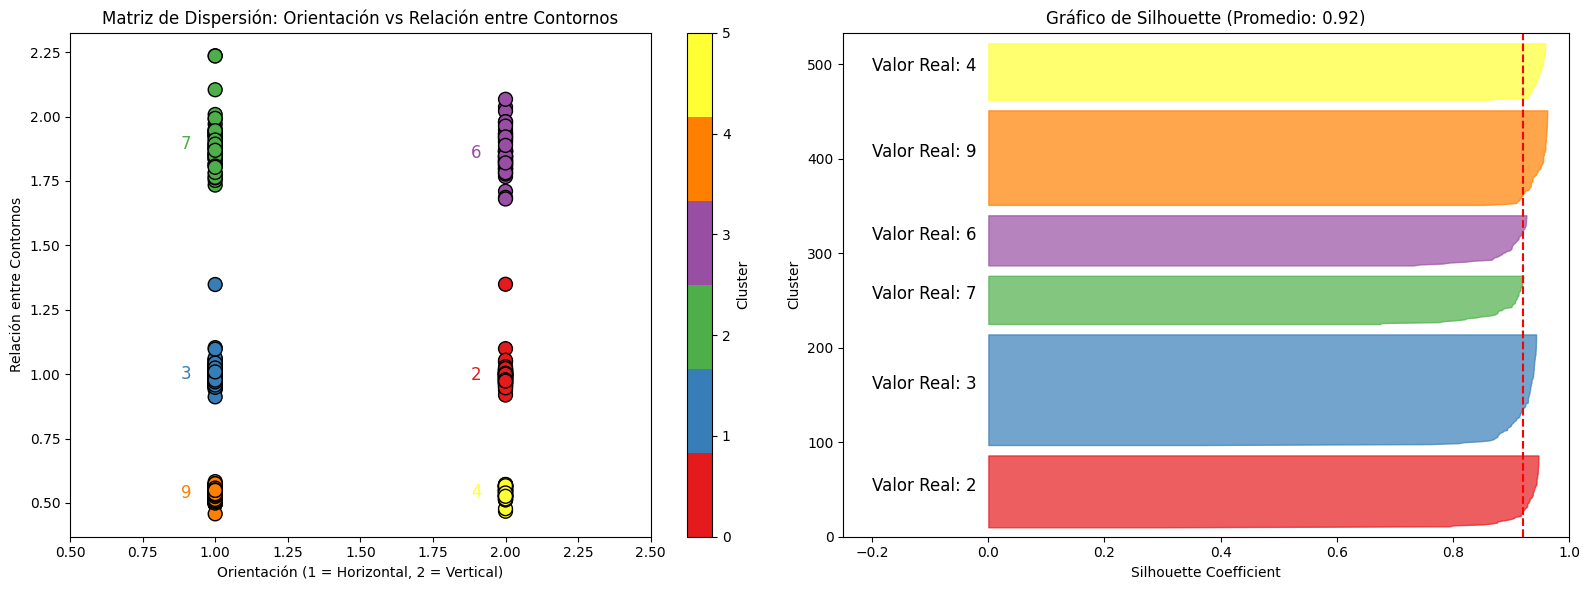

In [90]:
# Crear listas para almacenar las orientaciones, relaciones de área y valores reales
orientaciones = []  # Para almacenar las orientaciones (horizontal/vertical)
relaciones_area = []  # Para almacenar las relaciones de área entre los contornos
valores_reales = []  # Para almacenar los valores reales correspondientes a cada segmento

# Extraer los datos de los segmentos
for image_idx, segment_info in enumerate(new_segment_info_global):
    for segment_idx, segment in enumerate(segment_info):
        # Obtener la orientación del segmento (si existe)
        orientacion = segment["orientation"][0] if segment["orientation"] else None
        
        # Solo procesar segmentos con exactamente dos contornos
        if segment.get("num_contours", 0) == 2:
            relacion_area = segment.get("area_ratios_relation", None)
        
            # Obtener el valor real del segmento
            valor_real = segment.get("valor_real", None)
            
            # Si todos los datos son válidos (no son None), agregar a las listas
            if orientacion is not None and relacion_area is not None and valor_real is not None:
                orientaciones.append(orientacion)
                relaciones_area.append(relacion_area)
                valores_reales.append(valor_real)

# Convertir las listas a arrays de numpy para un manejo más fácil
orientaciones = np.array(orientaciones)
relaciones_area = np.array(relaciones_area)
valores_reales = np.array(valores_reales)

# Convertir las orientaciones a valores numéricos (1 para 'horizontal', 2 para 'vertical')
orientaciones_num = np.array([1 if orientacion == 'horizontal' else 2 for orientacion in orientaciones])

# Aplicar el algoritmo KMeans para realizar el clustering
# Los clusters se hacen en función de las orientaciones numéricas y relaciones de área
kmeans = KMeans(n_clusters=len(np.unique(valores_reales)), random_state=42)
clusters = kmeans.fit_predict(np.column_stack((orientaciones_num, relaciones_area)))

# Crear un mapa de colores basado en los clusters
cmap_clusters = ListedColormap(sns.color_palette("Set1", n_colors=len(np.unique(clusters))))

# Crear un diccionario para mapear cada clúster a un valor real
cluster_to_value_real = {}
for cluster_id in np.unique(clusters):
    # Obtener el valor real más común dentro de cada clúster
    value_real_for_cluster = np.unique(valores_reales[clusters == cluster_id])
    cluster_to_value_real[cluster_id] = value_real_for_cluster[0]  # Suponiendo que cada clúster tiene un único valor real

# Crear la figura y los ejes para ambos gráficos (dispersión y silhouette)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de dispersión con los clusters coloreados
scatter = ax1.scatter(orientaciones_num, relaciones_area, c=clusters, cmap=cmap_clusters, s=100, edgecolors="k")
ax1.set_xlabel("Orientación (1 = Horizontal, 2 = Vertical)")
ax1.set_ylabel("Relación entre Contornos")
ax1.set_title("Matriz de Dispersión: Orientación vs Relación entre Contornos")
ax1.set_xlim(0.5, 2.5)  # Limitar el eje X de 0.5 a 2.5 para que se vea claramente la distinción entre Horizontal y Vertical
fig.colorbar(scatter, ax=ax1, label="Cluster")

# Añadir los valores reales como etiquetas a la izquierda de cada cluster
for cluster_id, value_real in cluster_to_value_real.items():
    ax1.text(np.mean(orientaciones_num[clusters == cluster_id]) - 0.1,  # Desplazamos el texto a la izquierda
             np.mean(relaciones_area[clusters == cluster_id]), 
             str(value_real), color=cmap_clusters(cluster_id), 
             fontsize=12, ha='center', va='center')

# Calcular la Silhouette para los clusters
silhouette_vals = silhouette_samples(np.column_stack((orientaciones_num, relaciones_area)), clusters)
silhouette_avg = silhouette_score(np.column_stack((orientaciones_num, relaciones_area)), clusters)

# Gráfico de Silhouette
ax2.set_xlim([-0.25, 1])  # Cambiar el límite del eje X para que vaya de -0.25 a 1
ax2.set_ylim([0, len(orientaciones) + (len(np.unique(clusters)) + 1) * 10])  # Ajustar el límite Y

y_lower = 10  # Variable para la ubicación de las filas de los clusters
for i in np.unique(clusters):
    cluster_silhouette_vals = silhouette_vals[clusters == i]  # Obtener los valores de Silhouette de este cluster
    cluster_silhouette_vals.sort()  # Ordenar los valores

    size_cluster = cluster_silhouette_vals.shape[0]  # Tamaño del cluster
    y_upper = y_lower + size_cluster  # Definir el rango superior para este cluster

    # Dibujar la región de Silhouette para el cluster
    ax2.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, facecolor=cmap_clusters(i), edgecolor=cmap_clusters(i), alpha=0.7)
    # Añadir el valor real del cluster en el centro de la región de Silhouette
    ax2.text(-0.20, (y_lower + y_upper) / 2, f"Valor Real: {cluster_to_value_real[i]}", color='black', fontsize=12)
    
    y_lower = y_upper + 10  # Actualizar la posición para el siguiente cluster

# Añadir la línea vertical para el valor promedio de Silhouette
ax2.axvline(x=silhouette_avg, color="red", linestyle="--")
ax2.set_xlabel("Silhouette Coefficient")
ax2.set_ylabel("Cluster")
ax2.set_title(f"Gráfico de Silhouette (Promedio: {silhouette_avg:.2f})")

# Ajustar el layout para evitar solapamientos
plt.tight_layout()

# Mostrar ambos gráficos
plt.show()

C:\Users\paufe\AppData\Local\Temp\ipykernel_13292\1351528981.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Relación entre Contornos', data=data, palette="Set1")


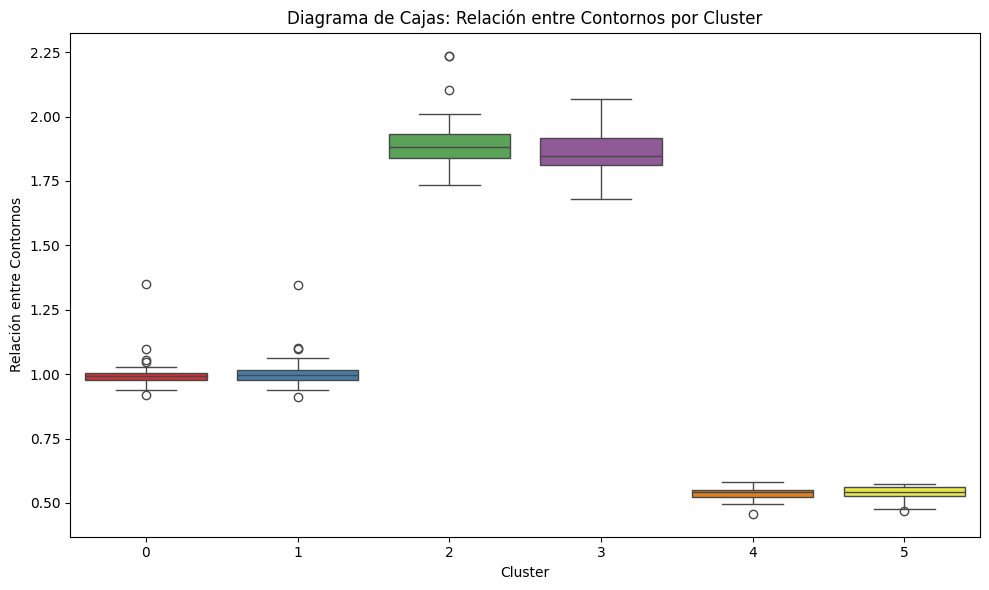

In [91]:
# Si 'relaciones_area' es una lista de listas, podemos tomar el promedio de cada lista
relaciones_area_promedio = [np.mean(area) if isinstance(area, (list, np.ndarray)) else area 
                            for area in relaciones_area]

# Crear un DataFrame con las relaciones de área promedio y los clusters
data = pd.DataFrame({
    'Relación entre Contornos': relaciones_area_promedio,
    'Cluster': clusters
})

# Crear el diagrama de cajas (boxplot) agrupado por clusters
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Relación entre Contornos', data=data, palette="Set1")

# Añadir título y etiquetas
plt.title("Diagrama de Cajas: Relación entre Contornos por Cluster")
plt.xlabel("Cluster")
plt.ylabel("Relación entre Contornos")

# Ajustar el layout y mostrar el gráfico
plt.tight_layout()
plt.show()


### Diagrama dispersión orientación vs area_ratios para segmentos con 1 contorno

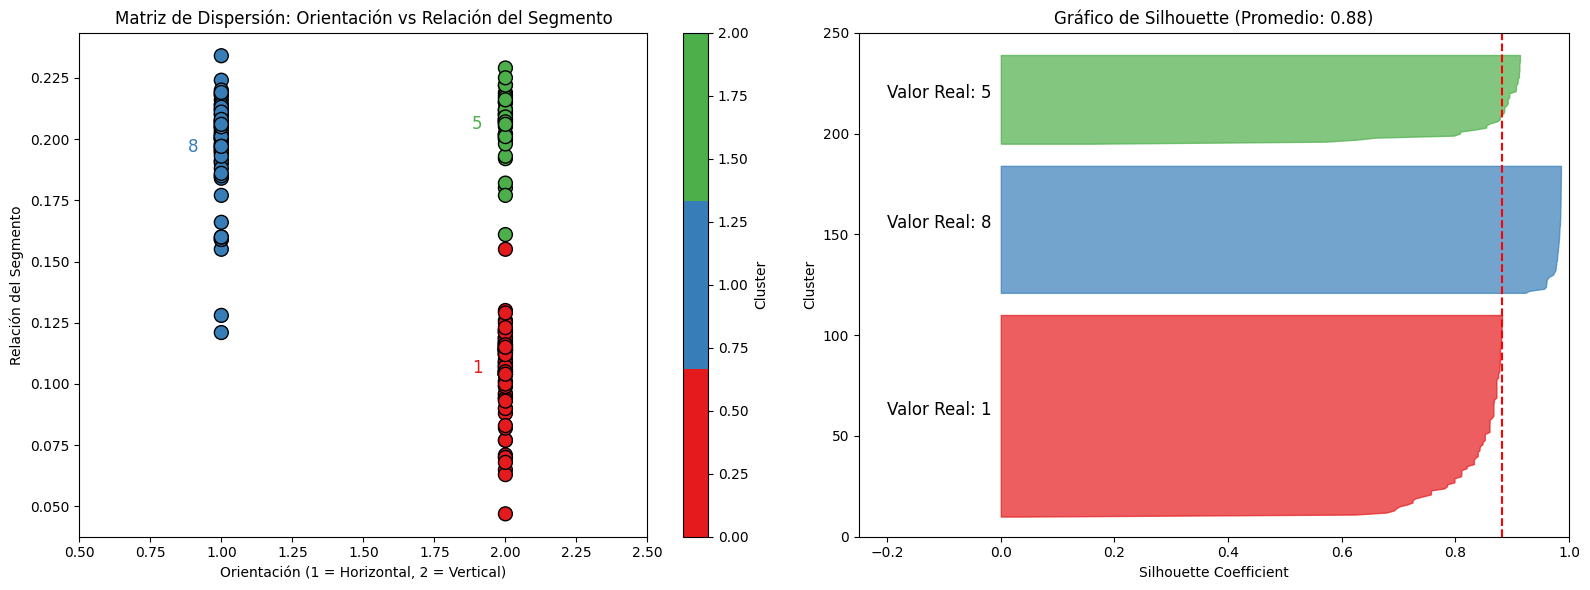

In [92]:
# Crear listas para almacenar las orientaciones, relaciones de área y valores reales
orientaciones = []  # Lista para almacenar las orientaciones de cada segmento
relaciones_area_segmento = []  # Lista para almacenar las relaciones de área de cada segmento
valores_reales = []  # Lista para almacenar los valores reales de cada segmento

# Extraer los datos de cada imagen y sus segmentos
for image_idx, segment_info in enumerate(new_segment_info_global):  # Iterar por cada imagen en la lista global de segmentos
    for segment_idx, segment in enumerate(segment_info):  # Iterar por cada segmento en la imagen
        # Obtener la orientación (horizontal o vertical)
        orientacion = segment["orientation"][0] if segment["orientation"] else None  # Si existe orientación, tomarla
        
        # Solo procesar segmentos con un solo contorno
        if segment.get("num_contours", 0) == 1:  # Comprobar si el número de contornos es 1
            relacion_area = segment.get("area_ratios", None)  # Obtener las relaciones de área, si existen
        
            # Obtener el valor real del segmento
            valor_real = segment.get("valor_real", None)  # Obtener el valor real si existe
            
            # Si todos los datos son válidos, agregar a las listas
            if orientacion is not None and relacion_area is not None and valor_real is not None:  # Verificar que todos los datos son válidos
                orientaciones.append(orientacion)  # Añadir la orientación a la lista
                relaciones_area_segmento.append(relacion_area)  # Añadir la relación de área a la lista
                valores_reales.append(valor_real)  # Añadir el valor real a la lista

# Convertir las listas a arrays de numpy para un manejo más fácil
orientaciones = np.array(orientaciones)  # Convertir la lista de orientaciones a un array numpy
relaciones_area_segmento = np.array(relaciones_area_segmento)  # Convertir la lista de relaciones de área a un array numpy
valores_reales = np.array(valores_reales)  # Convertir la lista de valores reales a un array numpy

# Convertir las orientaciones a valores numéricos (1 para 'horizontal', 2 para 'vertical')
orientaciones_num = np.array([1 if orientacion == 'horizontal' else 2 for orientacion in orientaciones])  # Mapear 'horizontal' a 1 y 'vertical' a 2

# Aplicar KMeans al clustering en función de las orientaciones numéricas y relaciones de área
kmeans = KMeans(n_clusters=len(np.unique(valores_reales)), random_state=42)  # Inicializar KMeans con un número de clusters igual a la cantidad de valores únicos reales
clusters = kmeans.fit_predict(np.column_stack((orientaciones_num, relaciones_area_segmento)))  # Aplicar KMeans y predecir los clusters

# Crear un mapa de colores basado en los clusters
cmap_clusters = ListedColormap(sns.color_palette("Set1", n_colors=len(np.unique(clusters))))  # Crear un mapa de colores con una paleta de colores

# Crear un diccionario para mapear cada clúster a un valor real
cluster_to_value_real = {}  # Diccionario vacío para almacenar los valores reales por clúster
for cluster_id in np.unique(clusters):  # Iterar por cada id de cluster único
    # Obtener el valor real más común dentro de cada clúster
    value_real_for_cluster = np.unique(valores_reales[clusters == cluster_id])  # Obtener los valores reales para ese cluster
    cluster_to_value_real[cluster_id] = value_real_for_cluster[0]  # Asignar el primer valor real al cluster

# Crear la figura y los ejes para ambos gráficos (dispersión y silhouette)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # Crear una figura con dos subgráficos (dispersión y silhouette)

# Gráfico de dispersión con los clusters coloreados
scatter = ax1.scatter(orientaciones_num, relaciones_area_segmento, c=clusters, cmap=cmap_clusters, s=100, edgecolors="k")  # Crear el gráfico de dispersión con colores según el cluster
ax1.set_xlabel("Orientación (1 = Horizontal, 2 = Vertical)")  # Etiqueta para el eje X
ax1.set_ylabel("Relación del Segmento")  # Etiqueta para el eje Y
ax1.set_title("Matriz de Dispersión: Orientación vs Relación del Segmento")  # Título del gráfico
ax1.set_xlim(0.5, 2.5)  # Limitar el eje X entre 0.5 y 2.5 para evitar que los puntos se salgan del rango
fig.colorbar(scatter, ax=ax1, label="Cluster")  # Añadir una barra de color para mostrar qué color corresponde a cada cluster

# Añadir los valores reales como etiquetas a la izquierda de cada cluster
for cluster_id, value_real in cluster_to_value_real.items():  # Iterar por cada cluster
    ax1.text(np.mean(orientaciones_num[clusters == cluster_id]) - 0.1,  # Colocar el texto un poco a la izquierda del centro del cluster
             np.mean(relaciones_area_segmento[clusters == cluster_id]),  # Centrar el texto en la media de la relación de área del cluster
             str(value_real), color=cmap_clusters(cluster_id),  # Colocar el valor real como texto y darle color según el cluster
             fontsize=12, ha='center', va='center')  # Ajustar el formato del texto

# Calcular la Silhouette para los clusters
silhouette_vals = silhouette_samples(np.column_stack((orientaciones_num, relaciones_area_segmento)), clusters)  # Calcular los valores de Silhouette por punto
silhouette_avg = silhouette_score(np.column_stack((orientaciones_num, relaciones_area_segmento)), clusters)  # Calcular el valor promedio de Silhouette

# Gráfico de Silhouette
ax2.set_xlim([-0.25, 1])  # Limitar el eje X del gráfico de silhouette de -0.25 a 1
ax2.set_ylim([0, len(orientaciones) + (len(np.unique(clusters)) + 1) * 10])  # Limitar el eje Y para que los clusters sean visibles

y_lower = 10  # Posición inicial del primer cluster en el eje Y
for i in np.unique(clusters):  # Iterar por cada cluster
    cluster_silhouette_vals = silhouette_vals[clusters == i]  # Obtener los valores de Silhouette para el cluster actual
    cluster_silhouette_vals.sort()  # Ordenar los valores de Silhouette del cluster

    size_cluster = cluster_silhouette_vals.shape[0]  # Obtener el tamaño del cluster
    y_upper = y_lower + size_cluster  # Establecer la posición final en el eje Y para el cluster

    ax2.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, facecolor=cmap_clusters(i), edgecolor=cmap_clusters(i), alpha=0.7)  # Dibujar la área del gráfico de Silhouette
    ax2.text(-0.20, (y_lower + y_upper) / 2, f"Valor Real: {cluster_to_value_real[i]}", color='black', fontsize=12)  # Añadir el valor real como texto al gráfico de Silhouette
    
    y_lower = y_upper + 10  # Actualizar la posición para el siguiente cluster

ax2.axvline(x=silhouette_avg, color="red", linestyle="--")  # Dibujar una línea vertical que marque el valor promedio de Silhouette
ax2.set_xlabel("Silhouette Coefficient")  # Etiqueta para el eje X
ax2.set_ylabel("Cluster")  # Etiqueta para el eje Y
ax2.set_title(f"Gráfico de Silhouette (Promedio: {silhouette_avg:.2f})")  # Título del gráfico de Silhouette

plt.tight_layout()  # Ajustar el diseño para que no se solapen los elementos
plt.show()  # Mostrar los gráficos


### Diagrama de cajas

C:\Users\paufe\AppData\Local\Temp\ipykernel_13292\3794402435.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Relación del Segmento', data=data, palette="Set1")


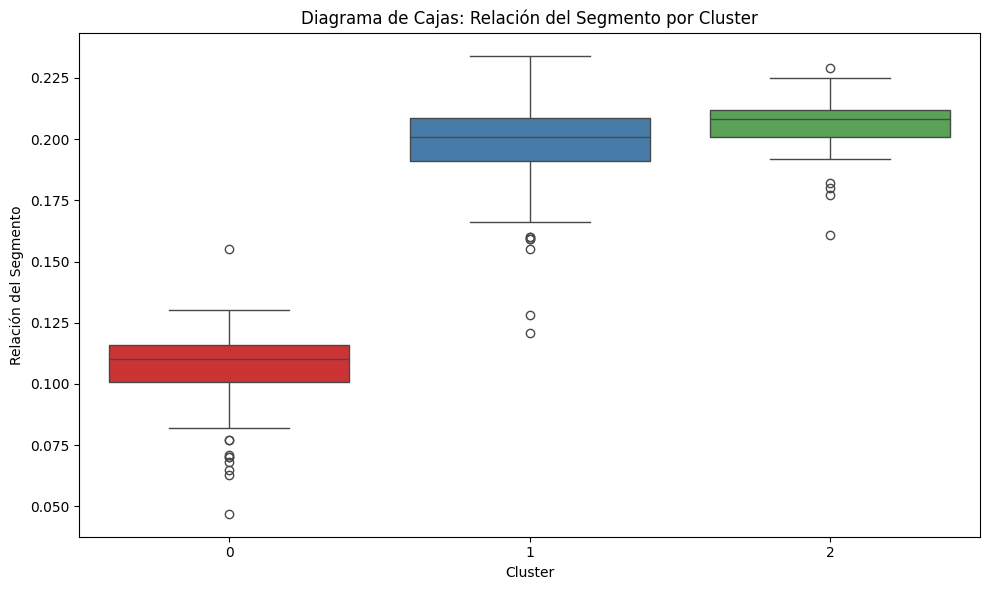

In [93]:
# Si 'relaciones_area' es una lista de listas, podemos tomar el promedio de cada lista
relaciones_area_promedio = [np.mean(area) if isinstance(area, (list, np.ndarray)) else area 
                            for area in relaciones_area_segmento]

# Crear un DataFrame con las relaciones de área promedio y los clusters
data = pd.DataFrame({
    'Relación del Segmento': relaciones_area_promedio,
    'Cluster': clusters
})

# Crear el diagrama de cajas (boxplot) agrupado por clusters
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Relación del Segmento', data=data, palette="Set1")

# Añadir título y etiquetas
plt.title("Diagrama de Cajas: Relación del Segmento por Cluster")
plt.xlabel("Cluster")
plt.ylabel("Relación del Segmento")

plt.tight_layout()
plt.show()


### Matriz de correlación de las características

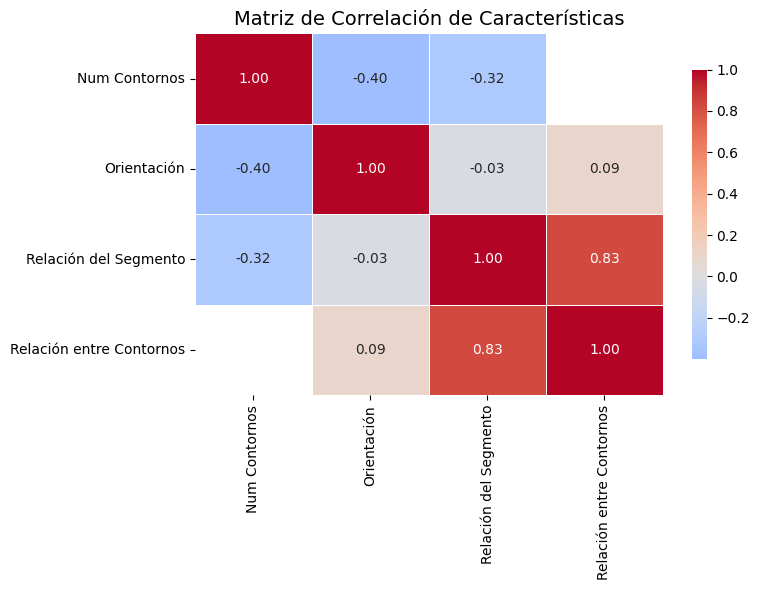

In [94]:
# Convertir 'Orientación' a valores numéricos (0 para 'horizontal' y 1 para 'vertical')
df["Orientación"] = df["Orientación"].apply(lambda x: 0 if x == "horizontal" else 1)

# Convertir 'Relación Área' a numérico si es necesario 
df["Relación entre Contornos"] = pd.to_numeric(df["Relación entre Contornos"], errors="coerce")

# Convertir 'Razones de Área' en listas de valores y extraer la primera relación de área (si es aplicable)
# Si 'Razones de Área' es una cadena con valores numéricos, debemos extraer el primer valor
df["Relación del Segmento"] = df["Relación del Segmento"].apply(lambda x: float(x.split(',')[0]) if x != "N/A" else None)

# Filtramos solo las columnas de interes para la matriz de correlación
df_numeric = df[["Num Contornos", "Orientación", "Relación del Segmento", "Relación entre Contornos"]]

# Calcular la matriz de correlación
correlation_matrix = df_numeric.corr()

# Visualizar la matriz de correlación usando un heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt='.2f', cbar_kws={"shrink": 0.8})

# Título del gráfico
plt.title("Matriz de Correlación de Características", fontsize=14)

# Mostrar el gráfico
plt.tight_layout()
plt.show()
